# Reinforcement Learning miniproject 

Nikolai Zaki & Oliver Atanaszov

Project repository:
    

In [16]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
from sarsa_demo import Agent, simulation, plot_cumulative_rewards, plot_learning_curve, plot_vectorfield, test_place

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Introduction

## Introduction

* plot of the place fields on the T-maze,
* visualize movement + activation
* briefly about the algorithm

In this report we present the results of our implementation of the SARSA algorithm with eligibility traces and function approximation. We implement and evaluate this algorithm for the task of sequentially reaching two different locations in a simple maze.

SARSA is an on policy algorithm that belongs to the category of reinforcement learning. The essence of the algorithm is to update the policy based on the reward expected under the current policy, in this it differs from the otherwise similar Q-learning algorithm which updates the policy based on the an ideal learning strategy. The main difference in outcome is that Q-learning can find a one time optimal solutioin while SARSA will find the a policy that maximizes the expected reward. Two additions are made to the original SARSA algortihm. First is the use of eligibility traces, which is a method of keeping track of past actions in order distribute credit over the series of actions that lead to a reward more appropriately. Second is the use of so-called function approximation by which a continuous state space can be used.

The goal is to simulate an agent (e.g. a mouse) that is moving inside a T-shaped maze and has to first move to a "pick-up" area before it proceeds to the target area where it receives a reward. Important here is that the agent does not receive a rewards for reaching the pick-up area. The only positive reward is thus collected upon completing the entire task. In addition to this there is a negative reward for running into a wall. Together these are reasonable describtion of tasks that real rodents might learn.

Specifically, the agent in the model received an input that was it position and generated as an output a movement step that consisted of a distance and a direction. The distance was drawn from a normal distribution, $\mathcal{N}(3,1.5^2)$, with units of cm. The direction was chosen by an $\epsilon-$greedy policy. As long as the agent had not completed the task the movement step was added to the original position in order to generate a new input. After each step the agents policy was updated to better reflect the value of the step it just performed based on any reward it received and the reward it expected to get from the next step. This update rule can be summarized as
\begin{equation}
\label{basic_update}
Q(a_t,s_t) \to \eta\big(r_t + \gamma Q(a_{t+1},s_{t+1}) - Q(a_t,s_t)\big) + Q(a_t,s_t),
\end{equation}
where $\eta$ represents the learning rate, $\gamma$ the discount factor applied to future expected rewards, $r_t$ the current reward and $Q(a_t,s_t)$ represents the expected reward of performing action $a_t$ in state $s_t$.

## Model Construction

In order to generate the output (action) of the agent from the input a two layered neural network was used (i.e. only input and output layer). The policy was thus encoded in the synaptic weights of the network and the policy update could be implemented by changing these weights.

### Input Layer

In rodents cells have been found that fire when the animal is in a specific location within its environment. The method of function approximation we used can be understood as analogous to these cells.

In order to encode the position of the agent, which is represented by an ordered tuple $\bar{x}\in \mathbb{R}^2$ a number positions in the maze were chosen at which the different nodes in the input layer would have high activity. In this way the conitinuous state space can be represented by a finite number of cells. Each of the cells received the current position as input and its acivity, $r_j$, was then commputed as
\begin{equation}
\label{place_cell_acivity}
r_j = \frac{1}{\sqrt{2\pi}\sigma}\exp(-\frac{||\bar{x}-\bar{x}_j||}{2\sigma^2}).
\end{equation}
The figure below shows the positions of the place cells, their color represents their activation if the input is located at the red 'x'.

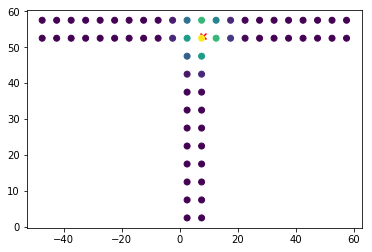

In [15]:
position = [8,53]
test_place(position)

Diverging from the biological realism another identical layer of input cells was created. The two layer were used to differentiate between the time before the agent had visited the pickup area and the time after. In the notation they are marked by the subscript $\beta$ which can take values 0 or 1 so $r_j$ above becomes $r_{j \alpha} = \delta_{\alpha \beta} r_j$ where $\beta$ is 0 if the agent has not visited the pick-up area and 1 if it has.

### Output Layer and Policy

In the output layer each cells corresponded to a different direction and its activation directly represented the Q values of the the policy so that 
\begin{equation}
\label{output_layer}
Q(a,s) = \sum_{j \alpha} w_{a \alpha j}r_{j \alpha}.
\end{equation}
This computation allows the agent to have two different Q-values for the same position by making its memory of having visited the pick-up area part of its current state.

### Weight Updates

The update rule for the Q-values as given in eq. \ref{basic_update} only distributes any reward found to the action-state pairs that came right before receiving the reward. This completely dismisses any relevance previous actions might have had towards received the reward. In order to alleviate this weakness of the algorithm eligibility traces can be used which keep track of the place cells that have recently active. This is done by Creating and array of the same dimesionality as the weight array and at each step adding the current activation to the elements corresponding to the actions taken at that step. In order to decrease the relevance of actions in the past these traces decay exponentially.

Let $e(a,s)$ be the trace value corresponding to action $a$ in state $s$. Then the update rule for the trace and $Q$-values is
\begin{equation}
\label{Q_update_rule}
e(a,s) \to \gamma \lambda e_{\alpha}(a,s) \\
e_{j}(a_t,s) \to e_{j}(a_t,s) + r_j(s) \textrm{for all }j \\
Q(a, s) \to \eta\big(r_t + \gamma Q(a_{t+1},s_{t+1})-Q(a_t,s_t)\big)e(a,s)+Q(a,s).
\end{equation}

A key difference to the naive update rule is that now all Q-values are updated. If we translate the update rule to the weights we have to introduce a subscript to differentiate the traces associated with different states of $\beta$, i.e. pick-up, it is then written as
\begin{equation}
\label{update_rule}
e_{\alpha}(a,s) \to \gamma \lambda e_{\alpha}(a,s) \\
e_{j\alpha}}(a_t,s) \to e_{j\alpha}}(a_t,s) + r_j(s) \textrm{for all }j \\
w_{a\alpha j} \to \eta\big(r_t + \gamma Q(a_{t+1},s_{t+1})-Q(a_t,s_t)\big)e_{\alpha}(a,s)+w_{a\alpha j}.
\end{equation}

## Mice Getting Their Cheese

With the model as described above the agents learn to solve the maze. Below is a series of trajectories of an agent, from completely naive to having trained 20 times.

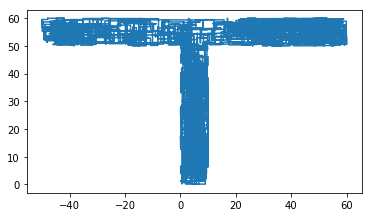

In [30]:
mouse = Agent()
mouse.trial(plot=True);

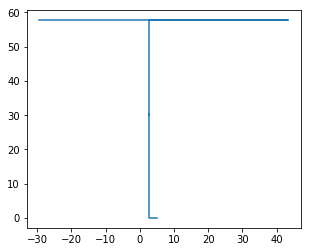

In [31]:
for i in range(18):
    mouse.trial()
mouse.trial(plot=True);

At first the agent explores the environment with movements that are practically all random. Indeed the agent uses an $\epsilon-$greedy policy with $\epsilon$ beginning at 0.9 and decreasing by a factor 0.8 each trial. 90% of the actions in the first trial are therefore entirely random, however the remaining 10% are based on a policy that is derived from randomly initialized weights, the agent might possibly learn a bit but this is practically random.

After 20 trials the agent can be seen to perform much better, following a very efficient trajectory. At this point the exploration parameter has decreased to around 1% so the agent can fully exploit what it learned.

# Model analysis

We now go into a more detail of the model and its performance. To this end we begin with the learning curves, i.e. the number of steps taken per trial to complete consecutive trials of the same agent. As can shortly be seen from the learning curves of individual agents the algorithm is not stable. That is to say that sometimes after several trials in which the agent completed the task efficiently it might take a very long time to complete the task. For this reason 20 agents are simulated here over 20 trials and in the learning curves we plot the average number of steps taken per trial.

Another thing to note with regards to stability of the algorithm is that the learning rate must be taken to be small, $\eta<0.1$, in order for the agent to be able to learn. The problem that occurs is that the Q-values diverge to the point where they become too large for the computer too handle. Even for $\eta \approx 0.1$ this can happen and we have here chosen $\eta=0.01$. However this is only a bandaid fix since the underlying problem is a lack of normalization in the algorithm. Such normalization would require knowledge (and thus computation) of all Q-values at all times instead of only the Q-values of the actions that can be undertaken in the current state.

For these reasons we included the $max_iter$ parameter in the simulation function, if the number of steps in a single trial exceeds the number thus specified the trial is aborted. 

In [33]:
cumulativeReward, latencies, aborts = simulation(Agent, nTrials = 50, nAgents = 20, nActions = 4, maxIter=1e5,
                      eps0 = .99,  decayRate = .95, gamma = .95, eta = 0.01, verbose = 0);

## Training

Below we show to figures of the learning rate, the first over all agents and the second only over the agents that did not have any aborted trials.
The transparent curves in the background show the learning

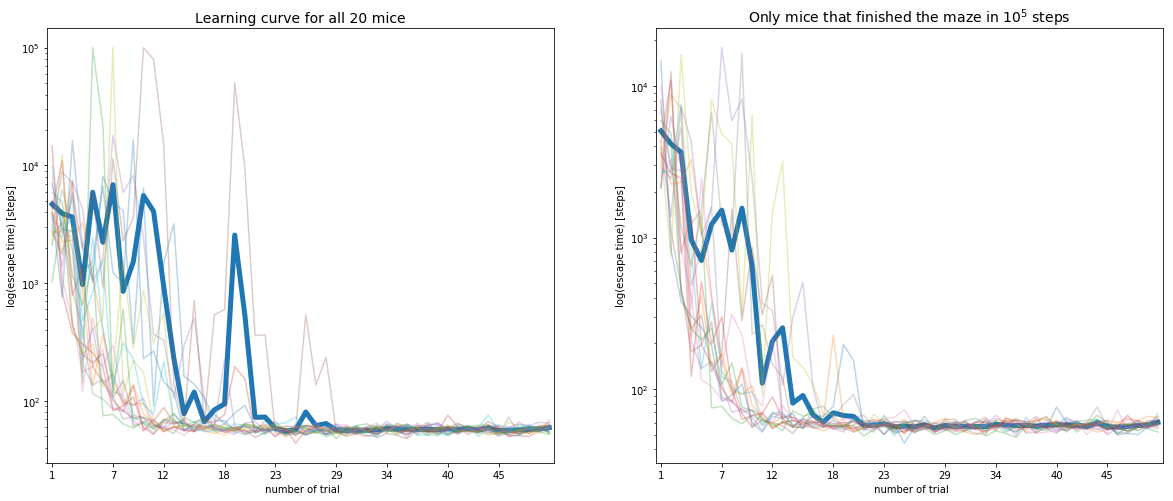

In [34]:
plot_learning_curve(latencies, aborts)

Fig. 1: Learning curves of 10 mice (colors) and the averaged curve (blue) over trial number. The y-axis shows in a logarithmic scale how many steps are needed for the mouse to escape the maze. Left: learning curves for all mice included, right: only the ones that escaped in max. $10^5$ steps.

### Rewards

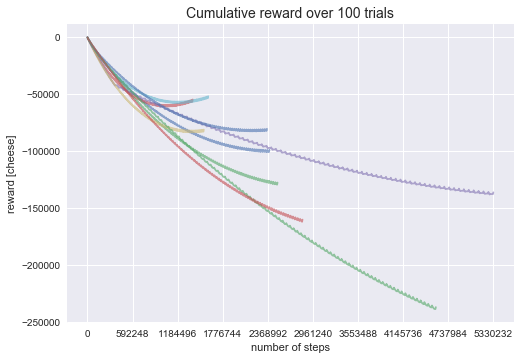

In [33]:
plot_cumulative_rewards(cumulativeReward, aborts)

Fig. 2: Cumulative rewards over steps for 10 mice and 100 trials (ie. the value of total gained reward up until the step number on the x-axis). 

### Visualization of the policy

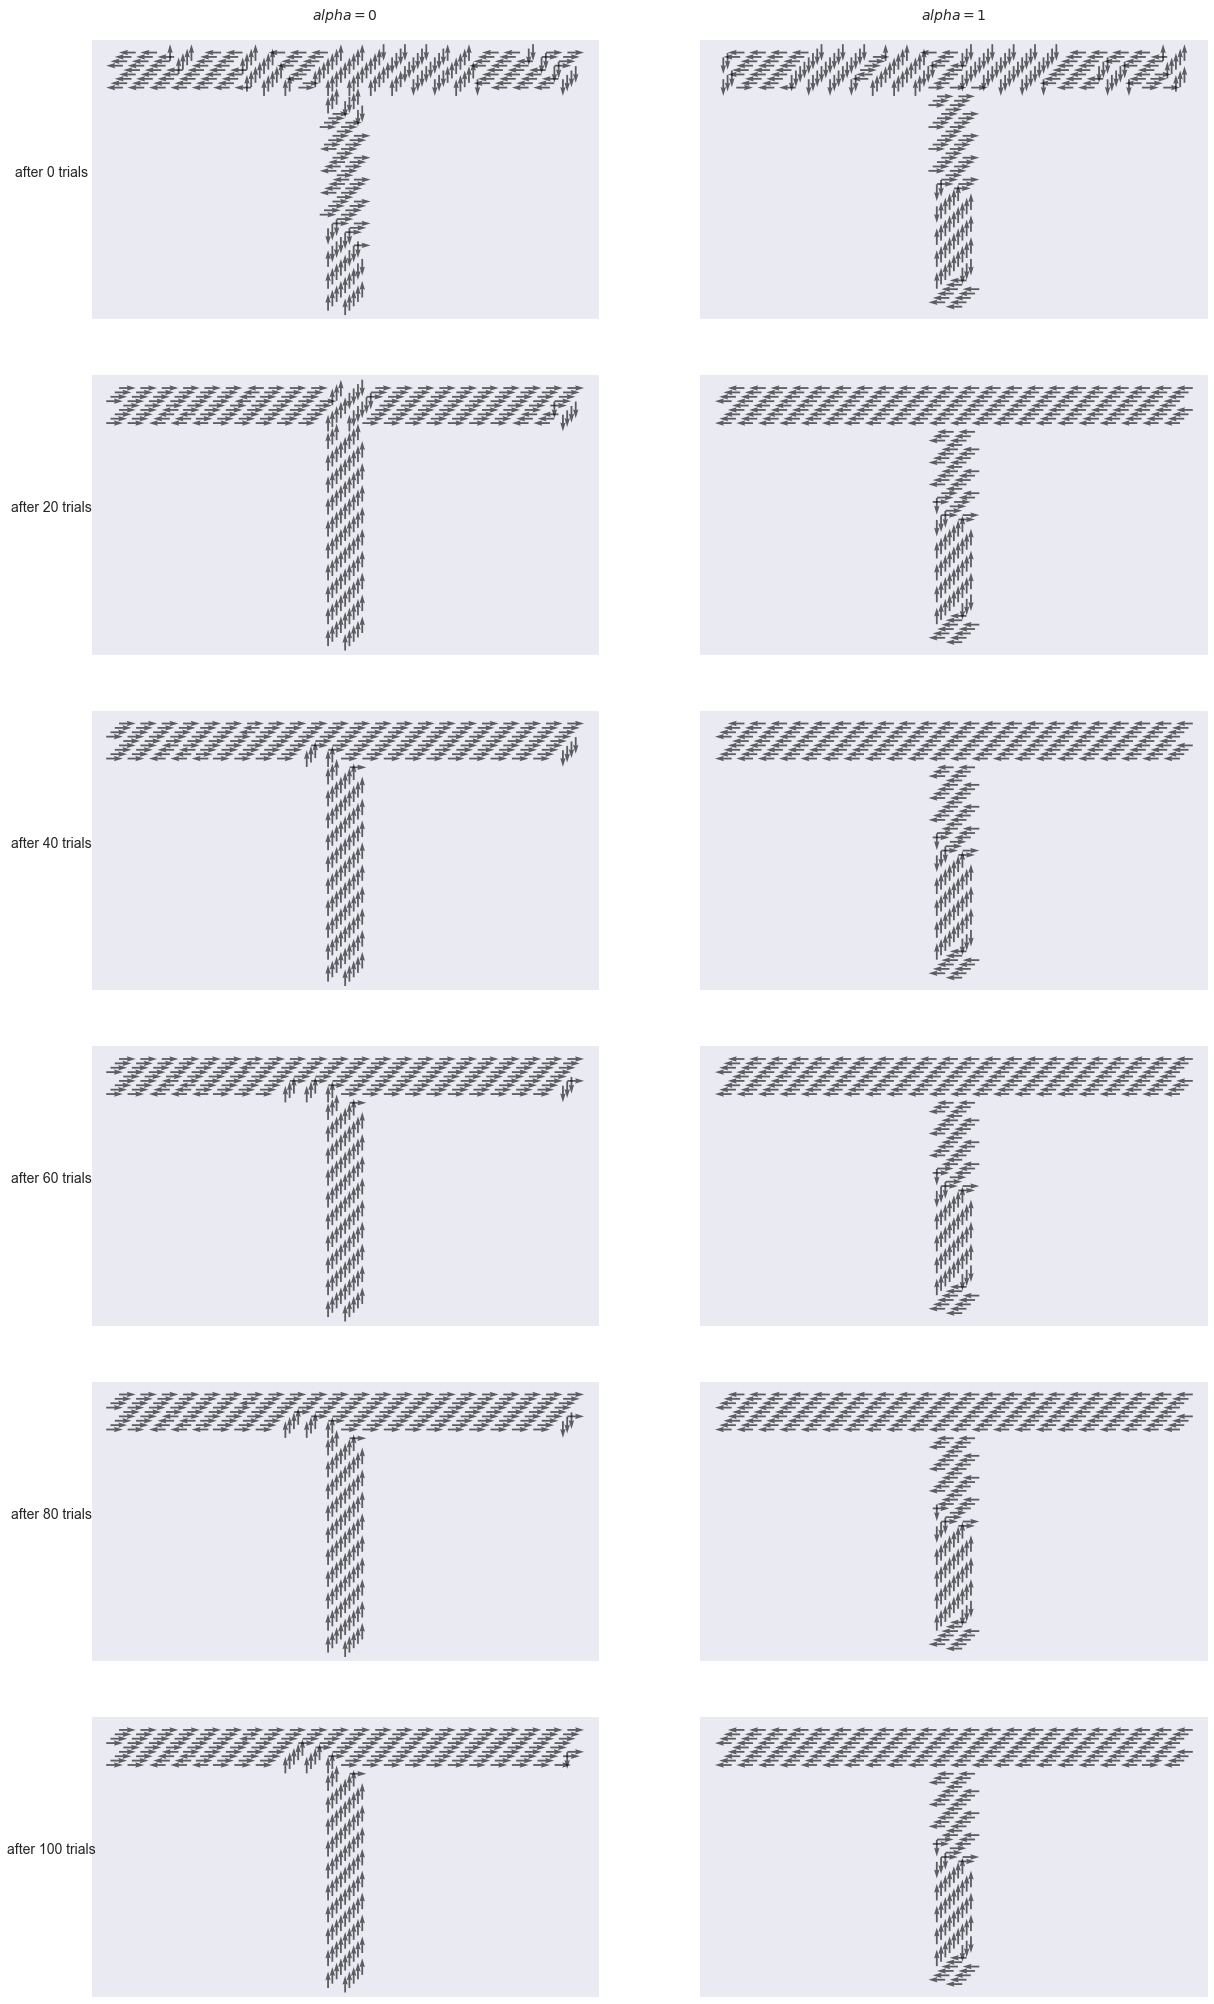

In [43]:
plot_vectorfield(Agent)

Fig. 3: Vector-fields of the policy determining the animals behaviour if it was acting in a maximum greedy manner (only exploitation). Left column: before finding the pickup area, right column: after finding the pickup area. From top to bottom the vector fields after increasing number of training trials are shown.